In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
import matplotlib.dates as mdates

# Publication color scheme
PUB_GRAY = '#cecece'
PUB_PURPLE = '#a559aa'
PUB_TEAL = '#59a89c'
PUB_GOLD = '#f0c571'
PUB_RED = '#e02b35'
PUB_BLUE = '#082a54'

def setup_publication_style():
    """
    Configure matplotlib parameters for publication-quality figures.
    
    This function sets up consistent styling for all plots including:
    - Font settings and mathematical typesetting
    - Figure size and resolution
    - Axis properties and grid styling
    - Line and marker properties
    - Tick direction and minor ticks
    - Legend styling
    - Save figure defaults
    """
    plt.rcParams.update({
        'font.size': 16,
        'font.family': 'Helvetica',
        'mathtext.fontset': 'stix',
        
        'figure.figsize': [10, 6],
        'figure.dpi': 300,
        
        'axes.linewidth': 1.2,
        'axes.labelsize': 16,
        'axes.grid': True,
        'axes.titlesize': 16,
        
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'lines.markeredgewidth': 1,
        
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
        
        'legend.fontsize': 16,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': False,
        'legend.framealpha': 0.95,
        
        'savefig.bbox': 'tight',
        'savefig.dpi': 300,
        'savefig.format': 'pdf'
    })

def calculate_phase_from_refractive_index(df, cavity_length=4.2, wavelength=1762e-9):
    """
    Calculate optical phase from refractive index measurements.
    
    The phase is calculated relative to the first measurement point using:
    phase = (n_current - n_reference) * (2π / wavelength) * cavity_length
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'n_1762' column (refractive index at 1762 nm)
    cavity_length : float, optional
        Optical cavity length in meters (default: 4.2 m)
    wavelength : float, optional
        Laser wavelength in meters (default: 1762e-9 m = 1762 nm)
        
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added 'phase_measured' column in radians
    tuple
        (T_ref, H_ref, P_ref, n_ref) - Reference values used for calculation
    """
    # Set reference values from first data point
    T_ref = df['temperature'].iloc[0]
    H_ref = df['humidity'].iloc[0]
    P_ref = df['pressure'].iloc[0] * 100  # Convert hPa to Pa
    n_ref = df['n_1762'].iloc[0]
    
    # Calculate phase using optical path difference
    conversion_factor = (2 * np.pi / wavelength) * cavity_length
    df['phase_measured'] = (df['n_1762'] - n_ref) * conversion_factor
    
    # Ensure time column is datetime type
    df['time'] = pd.to_datetime(df['time'])
    
    return df, (T_ref, H_ref, P_ref, n_ref)

def plot_environmental_phase_analysis(df, start_time=None, end_time=None, 
                                    save_path='environmental_phase_analysis.pdf'):
    """
    Create comprehensive analysis of environmental parameters and phase measurements.
    
    This function generates a multi-panel figure showing:
    - Time series of temperature, humidity, pressure
    - Correlations between environmental parameters and phase
    - Statistical analysis including R² values and linear fits
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 'time', 'temperature', 'humidity', 
        'pressure', 'n_1762'
    start_time : str, optional
        Start time for data filtering (format: 'YYYY-MM-DD HH:MM:SS+00:00')
    end_time : str, optional
        End time for data filtering (format: 'YYYY-MM-DD HH:MM:SS+00:00')
    save_path : str, optional
        Path to save the output figure
        
    Returns:
    --------
    tuple
        (df_processed, r2_values, reference_values)
        - df_processed: DataFrame with calculated phase measurements
        - r2_values: Dictionary of R² values for correlations
        - reference_values: Reference values used for phase calculation
        
    Example:
    --------
    >>> df_processed, r2_vals, ref_vals = plot_environmental_phase_analysis(
    ...     df, '2025-07-02 06:00:00+00:00', '2025-07-02 20:00:00+00:00',
    ...     'results/environmental_analysis.pdf')
    """
    
    def calculate_r2(x, y):
        """Calculate coefficient of determination (R²) between two variables"""
        correlation_matrix = np.corrcoef(x, y)
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy**2
        return r_squared
    
    # Setup publication style
    setup_publication_style()
    
    # Filter data for specific time range if provided
    if start_time and end_time:
        df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)].copy()
        print(f"Filtered data from {start_time} to {end_time}: {len(df_filtered)} points")
    else:
        df_filtered = df.copy()
        print(f"Using full dataset: {len(df_filtered)} points")
    
    # Calculate phase from refractive index
    df_processed, reference_values = calculate_phase_from_refractive_index(df_filtered)
    T_ref, H_ref, P_ref, n_ref = reference_values
    
    # Calculate R² values for correlations
    r2_temp = calculate_r2(df_processed['temperature'], df_processed['phase_measured'])
    r2_pres = calculate_r2(df_processed['pressure'], df_processed['phase_measured'])
    
    # Create the main figure with 3x2 grid layout (保持原有绘图代码)
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(3, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1])


    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(df_processed['time'], df_processed['temperature'], '.', alpha=0.2, color=PUB_TEAL, linewidth=1.5)
    ax1.set_ylabel('Temperature (°C)')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, va='top', ha='left', fontweight='bold')
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax2 = plt.subplot(gs[1, 0], sharex=ax1)
    ax2.plot(df_processed['time'], df_processed['humidity'], '.', alpha=0.2, color=PUB_TEAL, linewidth=1.5)
    ax2.set_ylabel('Humidity (%)')
    ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes, va='top', ha='left', fontweight='bold')
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax3 = plt.subplot(gs[2, 0], sharex=ax1)
    ax3.plot(df_processed['time'], df_processed['pressure'], '.', alpha=0.2, color=PUB_TEAL, linewidth=1.5)
    ax3.set_ylabel('Pressure (hPa)')
    ax3.set_xlabel('Time (UTC)')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax3.text(0.05, 0.95, '(c)', transform=ax3.transAxes, va='top', ha='left', fontweight='bold')

    ax4 = plt.subplot(gs[0, 1])
    ax4.scatter(df_processed['phase_measured'], df_processed['temperature'], alpha=0.2, s=15, c=PUB_GOLD, edgecolors='none')
    ax4.text(0.05, 0.95, '(d)', transform=ax4.transAxes, va='top', ha='left', fontweight='bold')
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)

    ax5 = plt.subplot(gs[1, 1], sharex=ax4)
    ax5.scatter(df_processed['phase_measured'], df_processed['humidity'], alpha=0.2, s=15, c=PUB_GOLD, edgecolors='none')
    ax5.text(0.05, 0.95, '(e)', transform=ax5.transAxes, va='top', ha='left', fontweight='bold')
    plt.setp(ax5.get_xticklabels(), visible=False)
    plt.setp(ax5.get_yticklabels(), visible=False)

    ax6 = plt.subplot(gs[2, 1], sharex=ax4)
    ax6.scatter(df_processed['phase_measured'], df_processed['pressure'], alpha=0.2, s=15, c=PUB_GOLD, edgecolors='none')
    ax6.set_xlabel('Phase (rad)')
    ax6.text(0.05, 0.95, '(f)', transform=ax6.transAxes, va='top', ha='left', fontweight='bold')
    plt.setp(ax6.get_yticklabels(), visible=False)

    z_temp = np.polyfit(df_processed['temperature'], df_processed['phase_measured'], 1)
    p_temp = np.poly1d(z_temp)
    ax4.plot(p_temp(df_processed['temperature']), df_processed['temperature'], color=PUB_GRAY, linewidth=2)

    z_pres = np.polyfit(df_processed['pressure'], df_processed['phase_measured'], 1)
    p_pres = np.poly1d(z_pres)
    ax6.plot(p_pres(df_processed['pressure']), df_processed['pressure'], color=PUB_GRAY, linewidth=2)

    plt.tight_layout(pad=0.2, h_pad=0.2)
    plt.savefig(save_path)
    plt.show()

    print("\n--- CAPTION VARIABLES ---")
    print(f"Temperature R² = {r2_temp:.3f}")
    print(f"Pressure R² = {r2_pres:.3f}")
    print("------------------------\n")
    
    r2_values = {
        'temperature': r2_temp,
        'pressure': r2_pres
    }
    
    return df_processed, r2_values, reference_values

Filtered data from 2025-07-02 06:00:00+00:00 to 2025-07-02 20:00:00+00:00: 2886 points


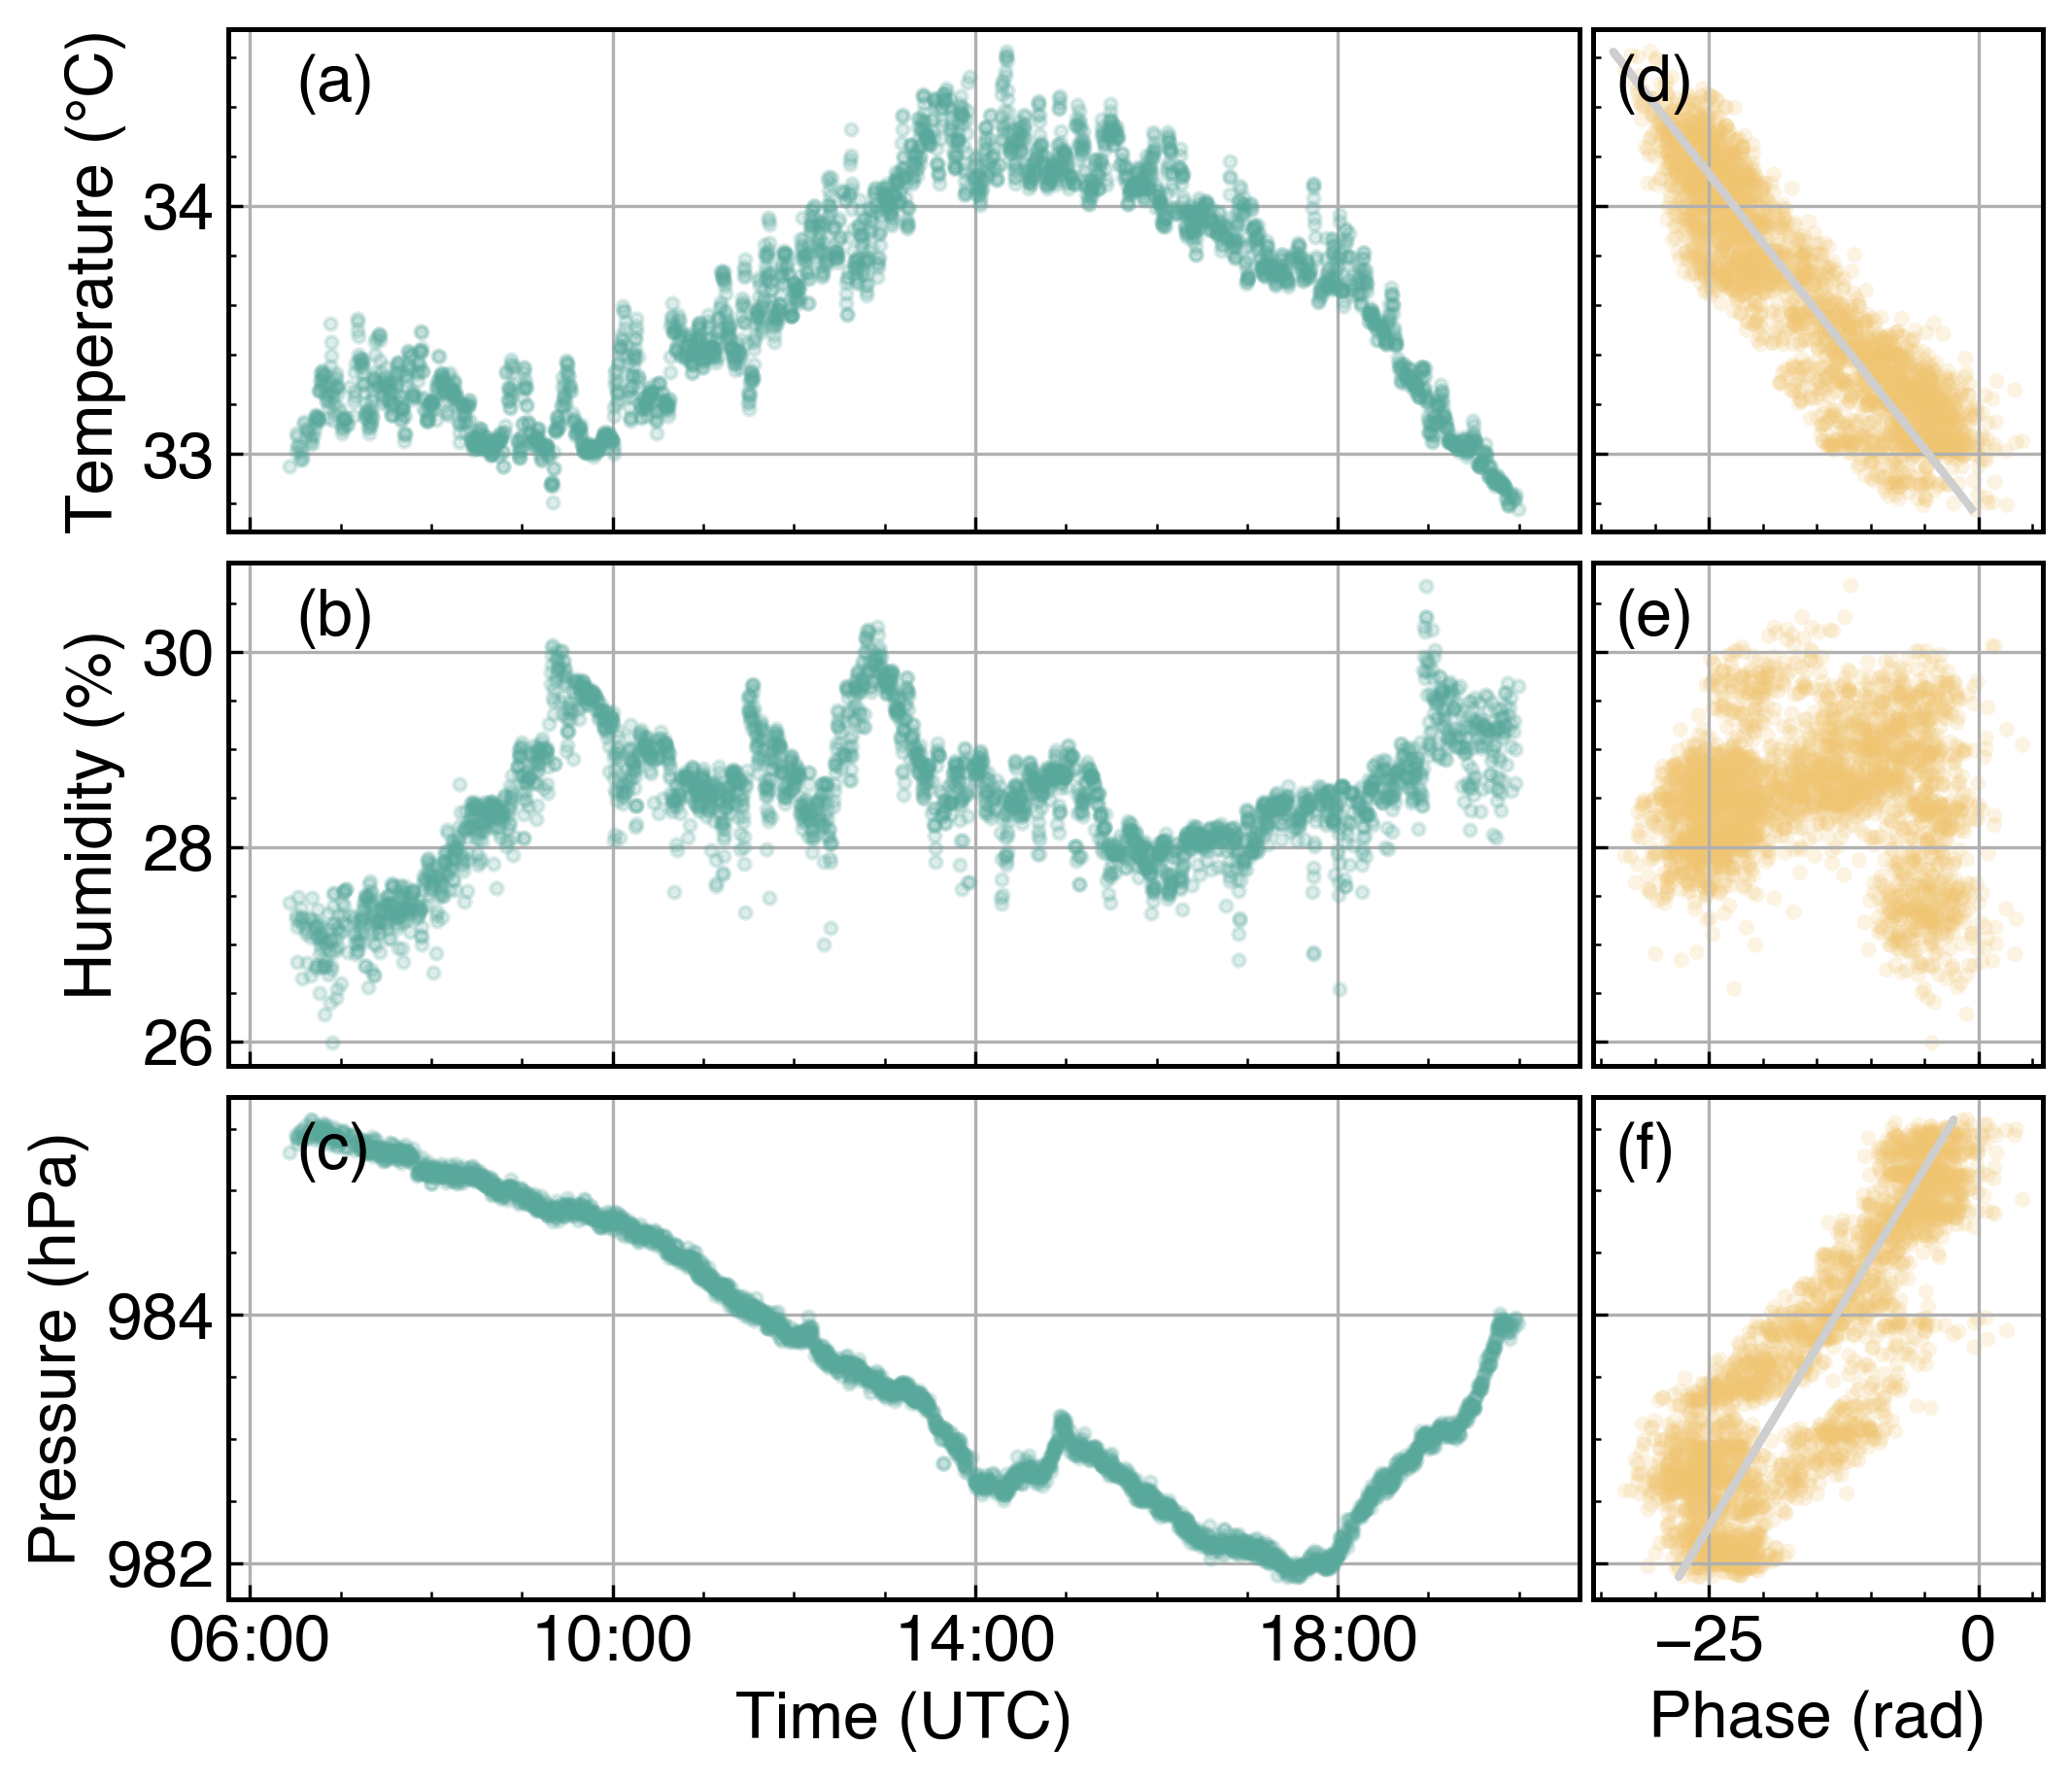


--- CAPTION VARIABLES ---
Temperature R² = 0.828
Pressure R² = 0.751
------------------------



In [2]:
df = pd.read_csv('../data/dataset_20250615_20250824_with_timestamp.csv')

# Run the analysis for a specific day
df_processed, r2_vals, ref_vals = plot_environmental_phase_analysis(
    df, 
    start_time='2025-07-02 06:00:00+00:00',
    end_time='2025-07-02 20:00:00+00:00',
    # save_path='environmental_phase_analysis.pdf'
    save_path='../figures/fig2_new.pdf'
)
